In [2]:
import pandas as pd
import glob
import numpy as np

import scipy
import scipy.sparse.linalg
# from lib.SinkhornKeops import TKeopsSinkhornSolverStandard as SinkhornSolver
#from pykeops.numpy import LazyTensor
import matplotlib.gridspec as gridspec
#import LinOT.SinkhornNP as Sinkhorn
import time
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit

In [69]:
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 1.8
matplotlib.rcParams['grid.linewidth'] = 1.0
matplotlib.rcParams['patch.linewidth'] = 1.8
matplotlib.rcParams['xtick.major.width'] = 1.6
matplotlib.rcParams['ytick.major.width'] = 1.6
matplotlib.rcParams['xtick.minor.width'] = 1.2
matplotlib.rcParams['ytick.minor.width'] = 1.2
# matplotlib.rcParams['legend.framewidth'] = 1.5
matplotlib.rcParams['font.weight'] = 'bold'

In [3]:
UseGPU = False
if UseGPU:
    import torch
    device = torch.device('cuda')

In [27]:
#plot

centm=1/2.54
#markerList=["1","3","2",".","+","x"]

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'cmr10','serif':['Computer Modern Roman'],'size':'20'})
plt.rc('axes.formatter', use_mathtext=True)

In [5]:
#load Provided data
files = glob.glob("./Given_results_convection/*")

#load newly generated data:
# files = glob.glob("./results_convection/*")


Res = pd.DataFrame({ "alphaXX" : [],
        "alphaYX" : [],
        "betaXX" : [],
        "betaYX" : [],
        "eps" : [],
        "eigval" : [],
        "eigvec" : [],
        "initOffset" : [],
        "skip" : [],
        "lag" : [],
        "rot" : [],
        "time" : []
        })
for A in files:
    D = np.load(A)
    Data = pd.DataFrame({ "alphaXX" : [D["alphaXX"]],
        "alphaYX" : [D["alphaYX"]],
        "betaXX" : [D["betaXX"]],
        "betaYX" : [D["betaYX"]],
        "eps" : [D["eps"]],
        "eigval" : [D["eigval"]],
        "eigvec" : [D["eigvec"]],
        "initOffset" : [D["initOffset"]],
        "skip" : [D["skip"]],
        "lag" : [D["lag"]],
        "rot" : [D["rot"]],
        "time" : [D["time"]]
        })
    Res = pd.concat([Res,Data],ignore_index=True)

In [6]:
#function for phase estimation
def SRS(T):
    T = T.reshape((3,8))
    avg = np.mean(T,axis = 1)
    res = [0,0,0]
    for j in [0,1,2]:    
        def test(k,delta,psi):
            return avg[j] + delta * np.cos(2*np.pi * k/8 - psi)
        param, param_cov = curve_fit(test, np.arange(8), T[j],bounds = ([0,0], [np.inf,2*np.pi]))
        res[j] = param[1]
    return res
def Phase_estimate(X):
    from multiprocessing import Pool
    if __name__ == '__main__':
        with Pool(128) as p:
            rs = p.map(SRS, X)
    return np.array(rs)

#Get subsampled X,Y coordinates:
def get_XY(rot,lag,skip,t0 = 2000):
    filename = "data_convection/1003261_sw_T.data"
    if(rot):
        filename = "data_convection/1102271_sw_T.data"
    
    posFull=np.loadtxt(filename,comments="#",delimiter="\t")
    posFull=posFull[t0:,2:].astype(np.float32)
    nFull=posFull.shape[0]
    nPts=1+(nFull-1-lag)//skip
    return posFull[0:skip*nPts:skip],posFull[lag:skip*nPts+lag:skip]

### Figure 5

In [8]:
X,_ = get_XY(rot = 0, lag = 1, skip = 60)
p_est = Phase_estimate(X)

In [9]:
SRS_loc = np.where(np.abs(np.abs(p_est[:,0] - p_est[:,2]) - np.pi) >= np.pi/2)
DRS_loc = np.where(np.abs(np.abs(p_est[:,0] - p_est[:,2]) - np.pi) < np.pi/2)
ColorList =  np.array((p_est[:,1]) % (2 * np.pi) ) * 1.
F5 = Res[(Res["skip"] == 60)&(Res["lag"] == 1)&(Res['rot'] == 0)]
Emb5 = F5[F5["eps"] == 0.1]["eigvec"].to_numpy()[0]
Eps = F5["eps"].to_numpy(dtype = float)
Eval = np.vstack(F5["eigval"].to_numpy()).real
argEps = np.argsort(Eps)
Eval = np.sort(Eval, axis = 1)

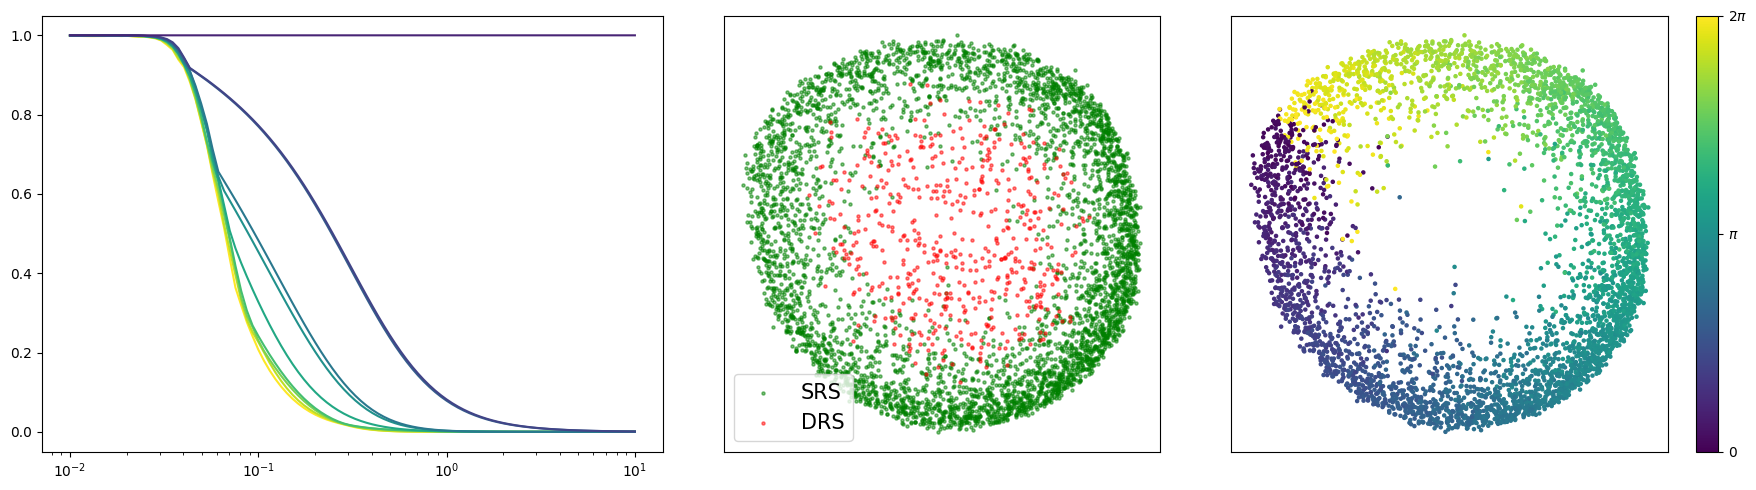

In [10]:
fig = plt.figure(figsize=(18, 5))

gs = gridspec.GridSpec(1, 3, width_ratios=[3, 2.5, 2.7])

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

#left plot
for i in range(10):
    y = Eval[:,i]
    ax1.plot(Eps[argEps],y[argEps], color = cm.viridis((10-i)/10))
ax1.set_xscale('log')

#middle plot
ax2.scatter(Emb5[:,1].real[SRS_loc],Emb5[:,2].real[SRS_loc],s=5,alpha=.5,label = 'SRS', color = 'green',rasterized=True)
ax2.scatter(Emb5[:,1].real[DRS_loc],Emb5[:,2].real[DRS_loc],s=5,alpha=.5,label = 'DRS', color = 'red',rasterized=True)
ax2.legend(fontsize = 15)
ax2.set_aspect('equal')
ax2.set_xticks([])
ax2.set_yticks([]) 

#right plot
im = ax3.scatter(Emb5[:,1].real[SRS_loc],Emb5[:,2].real[SRS_loc],s=5,alpha=1,c = ColorList[SRS_loc], vmax= 2 * np.pi, vmin = 0,rasterized=True)
ax3.set_aspect('equal')
ax3.set_xticks([])
ax3.set_yticks([]) 
cbar = fig.colorbar(im,ax = ax3,ticks = [0, np.pi ,2 * np.pi])
cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$']) 
fig.tight_layout()

plt.show()

### Figure 6

In [48]:
from lib.SinkhornNP import SolveOT
#Euc dist for pointclouds
def Cost(posX,posY):
    return ((posX.reshape((posX.shape[0],1,posX.shape[1])) - posY.reshape((1,posY.shape[0],posY.shape[1])))**2).sum(-1)

In [49]:
X_all, Y_all = get_XY(rot = 0, lag = 1, skip = 1)
X,Y = get_XY(rot = 0, lag = 1, skip = 60)
pts_all = X_all.shape[0]
pts = X.shape[0]

In [13]:
eps = 0.1
#Get OT plan and duals:
Res_XX = SolveOT(np.ones(pts)/pts,np.ones(pts)/pts,Cost(X,X),1e-7,eps,1,returnSolver = True)
EK_x = Res_XX[1].toarray() 
Res_YX = SolveOT(np.ones(pts)/pts,np.ones(pts)/pts,Cost(X,Y),1e-7,eps,1,returnSolver = True)
EK_y = Res_YX[1].toarray() 

In [14]:
#Out of sample emb:
def Get_extension(Xpt):
    xpot = 1/(np.sum(np.exp((-Cost(Xpt,X) + Res_XX[2].beta)/eps),axis=1))
    F_X = xpot[:,np.newaxis]*np.exp((-Cost(Xpt,X) + Res_XX[2].beta)/eps)*pts
    return EK_y@F_X.T


if UseGPU:
    tX = torch.tensor(X).to(device)
    tXbeta = torch.tensor(Res_XX[2].beta).to(device)
    tEK_x = torch.tensor(EK_x).to(device)
    tEK_y = torch.tensor(EK_y).to(device)
    #Out of sample emb in torch:
    def Get_extension(Xpt):
        Xpt = torch.tensor(Xpt).to(device)
        xpot = 1/(torch.sum(torch.exp((-Cost(Xpt,tX) + tXbeta)/eps),axis=1))
        F_X = xpot[:,torch.newaxis]*torch.exp((-Cost(Xpt,tX) + tXbeta)/eps)*pts
        return (tEK_y@F_X.T).cpu().numpy()

In [24]:
#subdevide the points to save memory:
PointSet = []
for k in range(11):
    PointSet += [X_all[k*30000 : min((k+1)*30000,pts_all)]]

#if you have Python 3.12 or newer
# PointSet = itertools.batched(X_all, 30000)

In [127]:
#get embedding and phase estimation:
t1 = time.time()
V1 = []
V2 = []
R = []
for S in PointSet:
    res = Phase_estimate(S)
    R += [res]
    Color_all = np.array(np.abs(np.abs(res[:,0] - res[:,2])-np.pi)<np.pi/2 , dtype = int) * 1.
    Mat = Get_extension(S)
    V1 += [(Mat.T@Emb5[:,1]).real]
    V2 += [(Mat.T@Emb5[:,2]).real]
print(time.time() - t1)

109.61424016952515


In [128]:
V1 = np.concatenate(V1).ravel()
V2 = np.concatenate(V2).ravel()
R = np.concatenate(R)
ind_DRS = np.where(np.abs(np.abs(R[:,0] - R[:,2])-np.pi) < np.pi/2)
ind_SRS = np.where(np.abs(np.abs(R[:,0] - R[:,2])-np.pi) >= np.pi/2)
Colorlist_all = np.array((R[:,1]) % (2 * np.pi) ) * 1.

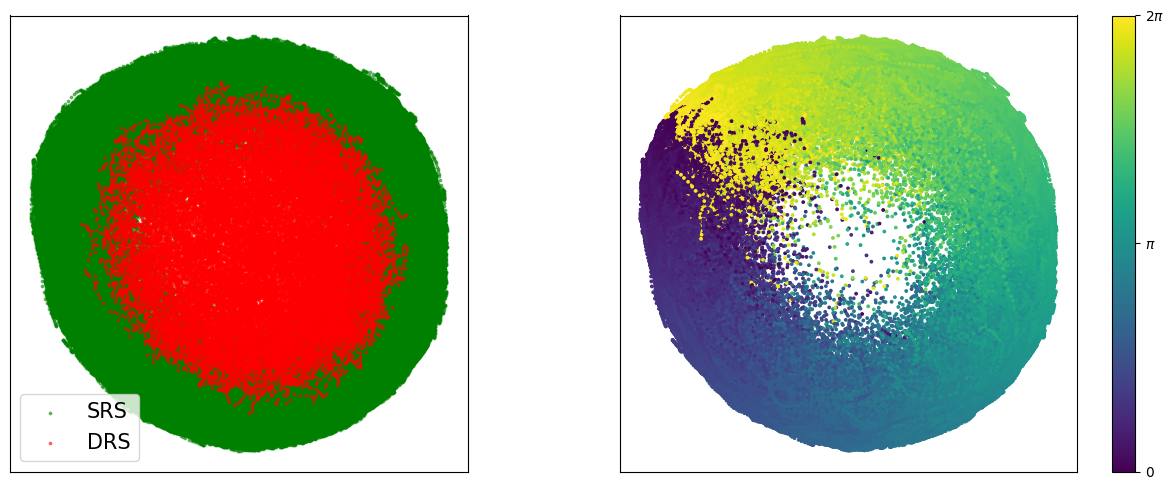

In [129]:
fig = plt.figure(figsize=(13, 5))

gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 3])

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


#left plot
ax1.scatter(V1[ind_SRS],V2[ind_SRS],color = 'green',rasterized=True,s=3,alpha=.5,label = 'SRS')
ax1.scatter(V1[ind_DRS],V2[ind_DRS],color = 'red',rasterized=True,s=3,alpha=.5,label = 'DRS')
ax1.legend(fontsize = 15)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([]) 

#right plot
im = ax2.scatter(V1[ind_SRS],V2[ind_SRS],c = Colorlist_all[ind_SRS],rasterized=True,s=3,vmin = 0, vmax = 2*np.pi)
ax2.set_xticks([])
ax2.set_yticks([]) 
ax2.set_aspect('equal')
cbar = fig.colorbar(im,ax = ax2,ticks = [0, np.pi ,2 * np.pi])
cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])  
fig.tight_layout()

plt.show()

### Figure 7

In [50]:
F7 = Res[(Res["rot"] == 0) & (Res["skip"] != 60) & (Res["lag"] == 1) & (Res["skip"] <= 14)]
F7 = pd.DataFrame(F7).drop_duplicates(subset = ["skip"])
sk = F7["skip"].to_numpy(dtype = float)
Eval = np.vstack(F7["eigval"].to_numpy()).real

In [51]:
lag = 1
N = np.hstack(1+(pts_all-1-lag)//F7["skip"].to_numpy())
Time = np.hstack(F7["time"].to_numpy())
Skip = np.hstack(F7["skip"].to_numpy())
argT = np.argsort(Time)[::-1]
Eval = Eval[argT]

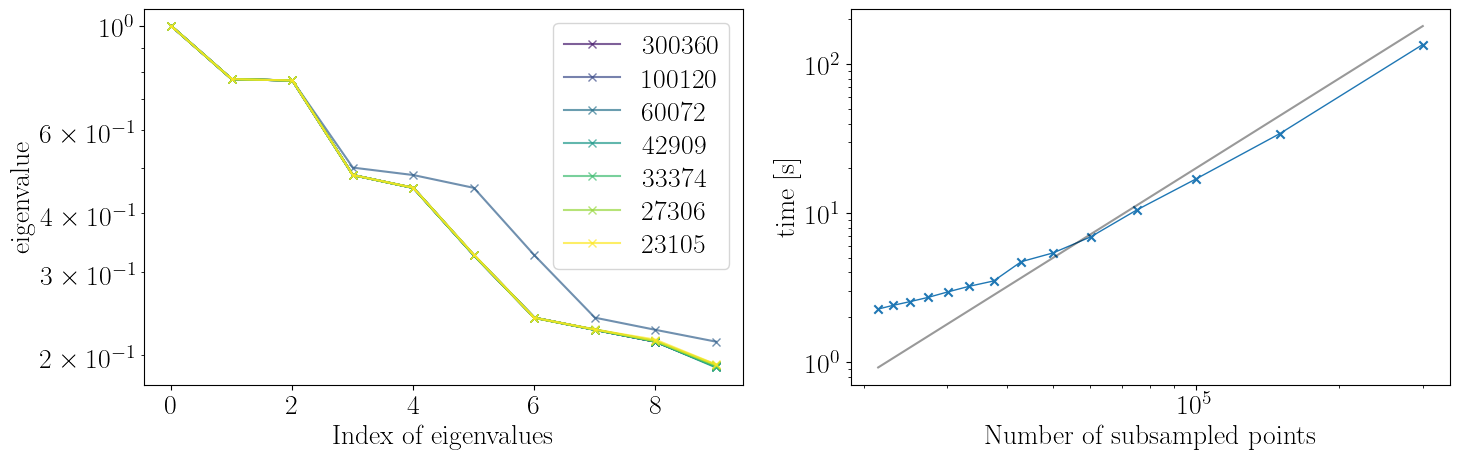

In [67]:
fig, ax = plt.subplots(1,2,figsize = (15,5))


#left plot
norm = matplotlib.colors.Normalize(
    vmin=int(min(sk)),
    vmax=int(max(sk)))
c_m = matplotlib.cm.viridis
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
for i,eigval in enumerate(Eval):
    if i % 2:
        ax[0].plot(np.sort(np.abs(eigval))[::-1]+0.00*i,marker="x",alpha=.7,color = s_m.to_rgba(sk[argT][i]), label = f"{1+(pts_all-1-lag)//i}")
    else:
        ax[0].plot(np.sort(np.abs(eigval))[::-1]+0.00*i,marker="x",alpha=.7,color = s_m.to_rgba(sk[argT][i]))
# ticklist = [1,3,5,7,9,11,13]
# cbar = fig.colorbar(s_m,ax = ax[0],ticks = ticklist)
# numlist = nPts=1+(pts_all-1-lag)//np.array(ticklist)
# cbar.ax.set_yticklabels([str(numlist[k]) for k in range(np.size(ticklist))]) 
ax[0].set_yscale('log')
ax[0].set_xlabel('Index of eigenvalues')
ax[0].set_ylabel('eigenvalue')
ax[0].legend(labelspacing = .3)

#right plot
ax[1].plot(N[argT],Time[argT],linewidth=1)
ax[1].scatter(N[argT],Time[argT], marker="x")
ax[1].plot(N[argT],2E-9*(N[argT])**2,c="k",alpha = .4)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Number of subsampled points')
ax[1].set_ylabel('time [s]')


fig.tight_layout()
# fig.legend(handles=ax[0].get_legend_handles_labels()[0],labels=[str(numlist[k]) for k in range(np.size(ticklist))],loc="center right",  bbox_to_anchor=(0.5, 0.5))

plt.savefig('./330360.pdf', format = 'pdf')


In [56]:
Eval.shape

(14, 10)

In [55]:
ax[0].get_legend_handles_labels()

([], [])

### Figure 8

In [9]:
X,Y = get_XY(rot = 1, lag = 1, skip = 1)
D8 = Res[(Res['rot'] == 1)&(Res['skip'] == 1)&(Res['eps'] <= .1)]
D81 = D8[(D8['eps'] == 0.1) & (D8['lag'] == 1)]
D82 = D8[(D8['lag'] == 1)]

In [10]:
p_est = Phase_estimate(X)

In [11]:
eigvec = np.vstack(D81['eigvec'].to_numpy())
SRS_loc = np.where(np.abs(np.abs(p_est[:,0] - p_est[:,2]) - np.pi) >= np.pi/2)
DRS_loc = np.where(np.abs(np.abs(p_est[:,0] - p_est[:,2]) - np.pi) < np.pi/2)
ColorList =  np.array((p_est[:,1]) % (2 * np.pi) ) * 1.
eigvals = np.vstack(D82["eigval"].to_numpy())
eps = np.hstack(D82["eps"].to_numpy())

In [25]:
from matplotlib.colors import ListedColormap
def darken_cmap(cmap, factor=0.6, n=256): # sample colors from the original colormap 
    colors = cmap(np.linspace(0, 1, n)) # darken by scaling RGB channels 
    colors[:, :3] = np.clip(colors[:, :3] * factor, 0, 1) 
    return ListedColormap(colors)
base = plt.cm.get_cmap('hsv', 256) 
dark_hsv = darken_cmap(base, factor=0.8)

/tmp/ipykernel_2133412/3388857430.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap('hsv', 256)


In [18]:
from matplotlib import colormaps

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2133412/3124154309.py:20: SyntaxWarning: invalid escape sequence '\p'
  cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])
/tmp/ipykernel_2133412/3124154309.py:20: SyntaxWarning: invalid escape sequence '\p'
  cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])


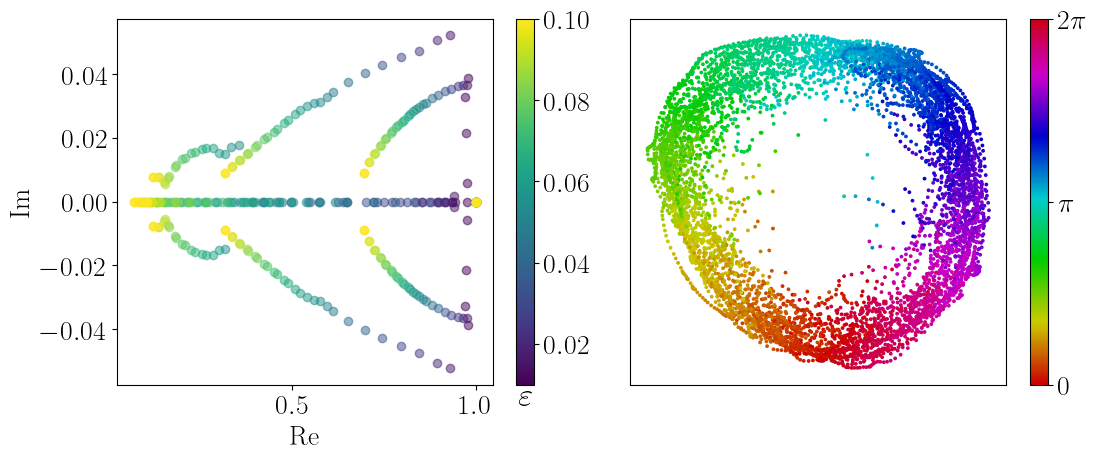

In [29]:
fig, ax = plt.subplots(1,2, figsize = (11.5,5))


#left plot
norm = matplotlib.colors.Normalize(
    vmin=min(eps),
    vmax=max(eps))
c_m = matplotlib.cm.viridis
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
for i in np.argsort(eps):
    ax[0].scatter(eigvals[i].real,eigvals[i].imag, color = s_m.to_rgba(eps[i]), alpha = .5, marker = 'o')
cb = plt.colorbar(s_m,ax=ax[0])
cb.ax.set_title('$\\varepsilon$', y = -.08)
ax[0].set_xlabel('Re')
ax[0].set_ylabel('Im')

#right plot
im = ax[1].scatter(eigvec[SRS_loc,1].real,eigvec[SRS_loc,1].imag, c = ColorList[SRS_loc], vmin = 0, vmax = 2*np.pi, s = 3,rasterized=True, cmap = dark_hsv)
cbar = fig.colorbar(im,ax = ax[1],ticks = [0, np.pi ,2 * np.pi])
cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])  
ax[1].set_xticks([])
ax[1].set_yticks([]) 

fig.tight_layout()
plt.savefig('spectrum_rainbow.pdf', format = 'pdf')

### Figure 9

In [30]:
D9a = Res[(Res['eps'] == .1)&(Res['rot'] == 1)&(Res['skip'] == 1)]
D9b = Res[(Res['eps'].isin([[num] for num in np.linspace(.05,.1,11)]))&(Res['rot'] == 1)&(Res['skip'] == 1)]

In [31]:
eigvals = np.vstack(D9a["eigval"].to_numpy())
lags = np.hstack(D9a["lag"].to_numpy())
eigvalsb = np.vstack(D9b["eigval"].to_numpy())
Eps = np.hstack(D9b["eps"].to_numpy())
lagsb = np.hstack(D9b["lag"].to_numpy())
orders=np.argsort(-np.abs(eigvalsb),axis=1)
phases=np.abs(np.angle(eigvalsb[np.arange(len(eigvalsb)),orders[:,1]]))

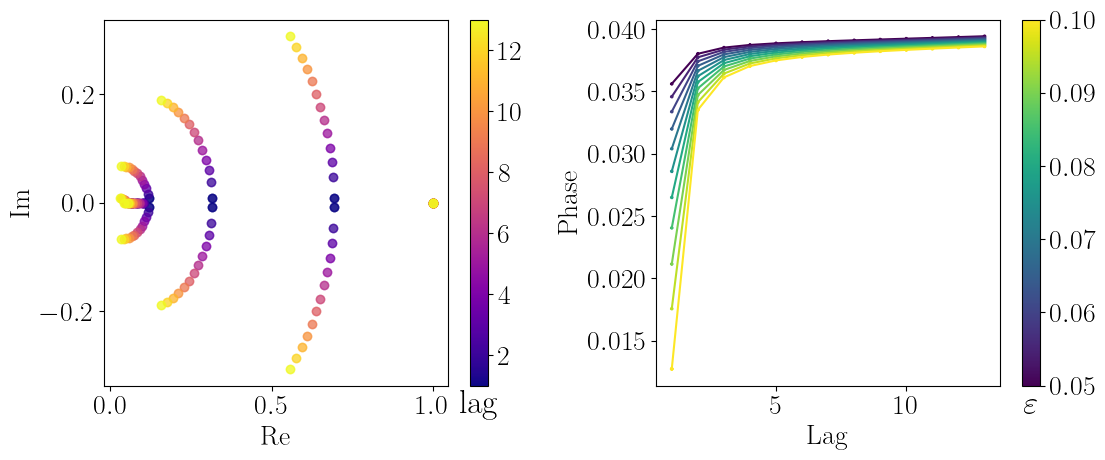

In [43]:
fig, ax = plt.subplots(1,2, figsize = (11.5,5))

#left plot
norm = matplotlib.colors.Normalize(
    vmin=min(lags),
    vmax=max(lags))
c_m = matplotlib.cm.viridis
c_m0 = matplotlib.cm.plasma
s_m0 = matplotlib.cm.ScalarMappable(cmap=c_m0, norm=norm)
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)

for i in np.argsort(lags):
    ax[0].scatter(eigvals[i].real,eigvals[i].imag, color = s_m0.to_rgba(lags[i]), alpha = .5, marker = 'o')
cb0 = plt.colorbar(s_m0,ax=ax[0])
cb0.ax.set_title('lag', y = -.1)
ax[0].set_xlabel('Re')
ax[0].set_ylabel('Im')


#right plot
normb = matplotlib.colors.Normalize(
    vmin=min(Eps),
    vmax=max(Eps))
c_mb = matplotlib.cm.viridis
s_mb = matplotlib.cm.ScalarMappable(cmap=c_mb, norm=normb)
Epslist = np.unique(np.hstack(D9b["eps"].to_numpy()))
for ep in Epslist:
    ind = np.where(Eps == ep)
    arglag = np.argsort(lagsb[ind])
    ax[1].plot(lagsb[ind][arglag],phases[ind][arglag]/lagsb[ind][arglag],c=s_mb.to_rgba(Eps[ind][0]), alpha = 1)
    ax[1].scatter(lagsb[ind][arglag],phases[ind][arglag]/lagsb[ind][arglag],c=s_mb.to_rgba(Eps[ind]), alpha = 1, marker= 'x', s = 3)
cb1 = plt.colorbar(s_mb,ax=ax[1])
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Phase')

cb1.ax.set_title('$\\varepsilon$', y = -.1)

fig.tight_layout()
plt.savefig('./evals10.pdf', format = 'pdf')